In [764]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, MinMaxScaler, StandardScaler, PolynomialFeatures, Binarizer, KBinsDiscretizer, OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.base import BaseEstimator, TransformerMixin
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels

In [600]:
data = pd.read_csv('dataset.csv')
data.drop_duplicates(inplace=True, ignore_index=True)

In [601]:
# bins = [0,18,25,30,35,40,50,60]
# labels=['sous poids','poids normal','surpoids','obésité modérée','obésité sévère','obésité morbide','obésité massive']

# data['BMI_cat']=pd.cut(data['bmi'], bins=bins, labels=labels, right=False)

# data.head()

In [602]:
# data['BMI_cat'].loc[data['bmi']==27.9][0]

In [774]:
class DropFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y = None):
        return self
    
    def get_feature_names_out(self, feature_names_out):
        return feature_names_out
    
    def fit_transform(self, X, y = None, **fit_params):
        return super().fit_transform(X, y, **fit_params)
    
    def transform(self, X):
        X_cop= X.copy()
        bins = [0,18,25,30,35,40,50,1000]
        labels=['sous poids','poids normal','surpoids','obésité modérée','obésité sévère','obésité morbide','obésité massive']
        X_cop['BMI_cat']=pd.cut(X_cop['bmi'], bins=bins, labels=labels, right=False)
        X_cop= X_cop.drop(['bmi'], axis=1)
        # X_dropped = X.drop(self.variables, axis = 1)
        # self.columns = X_dropped.columns
        return X_cop



In [604]:


X= data.drop(['charges'], axis=1)
y=data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])

In [605]:
X_train.shape

(1136, 6)

In [606]:
preprocessor = make_pipeline(DropFeatureSelector(),make_column_transformer((StandardScaler(), ['children','age']),
                                                     (OrdinalEncoder(), ['smoker', 'sex']), (OneHotEncoder(),['region',"BMI_cat"])), PolynomialFeatures(2))

In [607]:
#Linear Regression

model = make_pipeline(preprocessor, LinearRegression())

# print(model.get_params())

param_grid = {
    'pipeline__polynomialfeatures__degree': [1,2,3]
}

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=5,
    scoring='r2'
)


grid_search.fit(X_train, y_train)

print(grid_search.score(X_test,y_test))
print(grid_search.best_params_)





0.9207578898535984
{'pipeline__polynomialfeatures__degree': 2}


In [608]:
Lasso().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [609]:
#Lasso

lasso_model = make_pipeline(preprocessor, Lasso())

param_grid = {
    'lasso__alpha': np.linspace(1,100,50)
}

grid_search = GridSearchCV(
    lasso_model,
    param_grid,
    cv=5,
    scoring='r2'
)


grid_search.fit(X_train,y_train)
grid_search.best_params_
best_lasso_model=lasso_model.set_params(**grid_search.best_params_)

/home/addeche/Documents/Projets Python/Projet_assurance/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.271e+08, tolerance: 1.315e+07
  model = cd_fast.enet_coordinate_descent(
/home/addeche/Documents/Projets Python/Projet_assurance/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.494e+07, tolerance: 1.381e+07
  model = cd_fast.enet_coordinate_descent(
/home/addeche/Documents/Projets Python/Projet_assurance/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might wa

In [731]:
value_tranfo = best_lasso_model[:-1].fit_transform(X_train)

In [729]:
coef_names = best_lasso_model[:-1].get_feature_names_out()

In [735]:
type(coef_names.T)

numpy.ndarray

In [732]:
type(value_tranfo)

numpy.ndarray

In [750]:
# my_dict = {'col_name':coef_names, 'values': value_tranfo}


df_ols = pd.DataFrame(value_tranfo, columns=coef_names, index=y_train.index)
df_ols

,1,standardscaler__children,standardscaler__age,ordinalencoder__smoker,ordinalencoder__sex,onehotencoder__region_northeast,onehotencoder__region_northwest,onehotencoder__region_southeast,onehotencoder__region_southwest,onehotencoder__BMI_cat_obésité massive,...,onehotencoder__BMI_cat_obésité sévère^2,onehotencoder__BMI_cat_obésité sévère onehotencoder__BMI_cat_poids normal,onehotencoder__BMI_cat_obésité sévère onehotencoder__BMI_cat_sous poids,onehotencoder__BMI_cat_obésité sévère onehotencoder__BMI_cat_surpoids,onehotencoder__BMI_cat_poids normal^2,onehotencoder__BMI_cat_poids normal onehotencoder__BMI_cat_sous poids,onehotencoder__BMI_cat_poids normal onehotencoder__BMI_cat_surpoids,onehotencoder__BMI_cat_sous poids^2,onehotencoder__BMI_cat_sous poids onehotencoder__BMI_cat_surpoids,onehotencoder__BMI_cat_surpoids^2
1094,1.0,2.452595,-1.508889,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
94,1.0,0.768613,1.766367,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
349,1.0,-0.915369,-1.437688,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
410,1.0,-0.915369,-1.437688,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
981,1.0,1.610604,-0.583273,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,1.0,-0.915369,0.413544,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
752,1.0,-0.915369,1.339160,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
319,1.0,-0.073378,-0.512072,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
934,1.0,-0.915369,1.410361,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [749]:
y_train

1094     4561.18850
94      47291.05500
349      1635.73365
410      1621.34020
981     19199.94400
           ...     
674      7222.78625
752     11833.78230
319      4667.60765
934     12233.82800
1113     2396.09590
Name: charges, Length: 1136, dtype: float64

In [ ]:
y_train_smf = 

In [752]:
import statsmodels.api as smf


reg_multi = smf.OLS(y_train, df_ols).fit()

In [754]:
reg_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     98.56
Date:                Wed, 15 Jan 2025   Prob (F-statistic):               0.00
Time:                        12:14:03   Log-Likelihood:                -11158.
No. Observations:                1136   AIC:                         2.246e+04
Df Residuals:                    1066   BIC:                         2.281e+04
Df Model:                          69                                         
Covariance Type:            nonrobust                                         
=================================================================================================================================================
                                                                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------
1                                                                              4452.7876    439.948     10.121      0.000    3589.525    5316.050
standardscaler__children                                                        660.2498    821.393      0.804      0.422    -951.481    2271.980
standardscaler__age                                                            2724.1228    527.828      5.161      0.000    1688.423    3759.822
ordinalencoder__smoker                                                          1.11e+04    532.640     20.835      0.000    1.01e+04    1.21e+04
ordinalencoder__sex                                                            -475.6553    275.835     -1.724      0.085   -1016.896      65.585
onehotencoder__region_northeast                                                1426.9536    231.929      6.153      0.000     971.865    1882.043
onehotencoder__region_northwest                                                1273.7502    289.187      4.405      0.000     706.310    1841.191
onehotencoder__region_southeast                                                1039.6919    247.988      4.193      0.000     553.091    1526.293
onehotencoder__region_southwest                                                 712.3920    337.991      2.108      0.035      49.188    1375.596
onehotencoder__BMI_cat_obésité massive                                         -107.3641   1371.334     -0.078      0.938   -2798.185    2583.457
onehotencoder__BMI_cat_obésité modérée                                          707.5273    322.044      2.197      0.028      75.615    1339.440
onehotencoder__BMI_cat_obésité morbide                                          463.1413    452.140      1.024      0.306    -424.043    1350.326
onehotencoder__BMI_cat_obésité sévère                                           845.6803    352.647      2.398      0.017     153.719    1537.642
onehotencoder__BMI_cat_poids normal                                             650.2706    348.387      1.867      0.062     -33.331    1333.872
onehotencoder__BMI_cat_sous poids                                              1359.5951   1302.127      1.044      0.297   -1195.428    3914.618
onehotencoder__BMI_cat_surpoids                                                 533.9372    321.681      1.660      0.097     -97.262    1165.136
standardscaler__children^2                                                     -111.7851    134.211     -0.833      0.405    -375.133     151.563
standardscaler__children standardscaler__age                                     19.6185    154.835      0.127      0.899    -284.197     323.434
standardscaler__c

In [766]:
alpha = 0.05
p = df_ols.shape[1]
n = y_train.shape[0]

In [767]:
print(n , p)

1136 136


In [768]:
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})

In [769]:
analyses

,obs
0,1
1,2
2,3
3,4
4,5
...,...
1131,1132
1132,1133
1133,1134
1134,1135


In [770]:
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

seuil_levier = 2*p/n

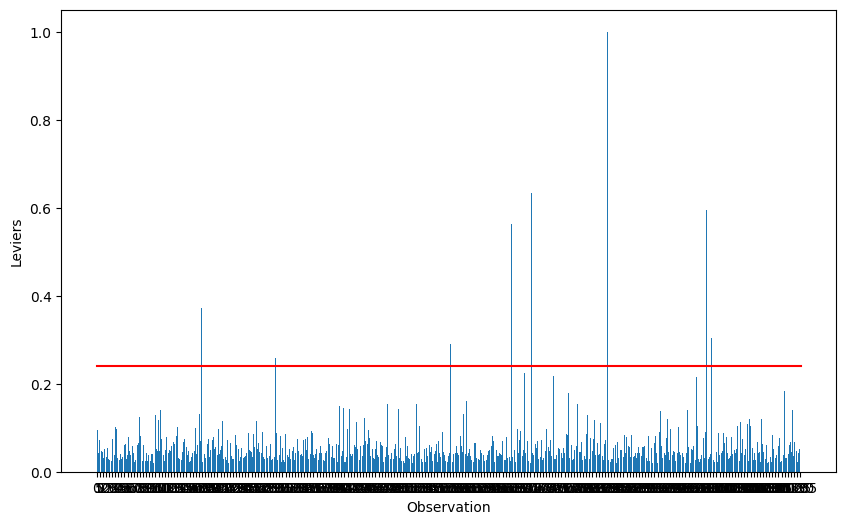

In [773]:
plt.figure(figsize=(10,6))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, 1136, step=5))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, 1136], [seuil_levier, seuil_levier], color='r')
plt.show()

In [700]:
preprocessor[2]

PolynomialFeatures()

In [777]:
best_lasso_model[:-1]

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('dropfeatureselector', DropFeatureSelector()),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('standardscaler',
                                                                   StandardScaler(),
                                                                   ['children',
                                                                    'age']),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(),
                                                                   ['smoker',
                                                                    'sex']),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(),
                                                                   ['region',
                                                                    'BMI_cat'])])),
                                 ('polynomialfeatures',
                                  PolynomialFeatures())]))])

In [680]:
len(best_lasso_model[0].fit_transform(X_train,y_train))

1136

In [676]:
best_lasso_model[:-1].get_feature_names_out()

array(['1', 'standardscaler__children', 'standardscaler__age',
       'ordinalencoder__smoker', 'ordinalencoder__sex',
       'onehotencoder__region_northeast',
       'onehotencoder__region_northwest',
       'onehotencoder__region_southeast',
       'onehotencoder__region_southwest',
       'onehotencoder__BMI_cat_obésité massive',
       'onehotencoder__BMI_cat_obésité modérée',
       'onehotencoder__BMI_cat_obésité morbide',
       'onehotencoder__BMI_cat_obésité sévère',
       'onehotencoder__BMI_cat_poids normal',
       'onehotencoder__BMI_cat_sous poids',
       'onehotencoder__BMI_cat_surpoids', 'standardscaler__children^2',
       'standardscaler__children standardscaler__age',
       'standardscaler__children ordinalencoder__smoker',
       'standardscaler__children ordinalencoder__sex',
       'standardscaler__children onehotencoder__region_northeast',
       'standardscaler__children onehotencoder__region_northwest',
       'standardscaler__children onehotencoder__region

In [611]:
X_test.head()

,age,sex,bmi,children,smoker,region
490,19,female,32.90,0,no,southwest
1206,36,male,33.40,2,yes,southwest
704,33,female,32.90,2,no,southwest
312,43,male,35.97,3,yes,southeast
57,18,male,31.68,2,yes,southeast


In [612]:
type(X_test)

pandas.core.frame.DataFrame

In [613]:
test = pd.DataFrame(X_test.iloc[0]).transpose()

In [614]:
best_lasso_model.fit(X_train, y_train)

print("Train score : ", best_lasso_model.score(X_test,y_test))

Train score :  0.9225791626656212


In [664]:
best_lasso_model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('dropfeatureselector', DropFeatureSelector()),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('standardscaler',
                                                                   StandardScaler(),
                                                                   ['children',
                                                                    'age']),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(),
                                                                   ['smoker',
                                                                    'sex']),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(),
                                                                   ['region',
                                                                    'BMI_cat'])])),
                                 ('polynomialfeatures',
                                  PolynomialFeatures())])),
                ('lasso', Lasso(alpha=np.float64(27.265306122448976)))])

In [ ]:
best_lasso_model[]

In [615]:
print(best_lasso_model)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('dropfeatureselector', DropFeatureSelector()),
                                 ('columntransformer',
                                  ColumnTransformer(transformers=[('standardscaler',
                                                                   StandardScaler(),
                                                                   ['children',
                                                                    'age']),
                                                                  ('ordinalencoder',
                                                                   OrdinalEncoder(),
                                                                   ['smoker',
                                                                    'sex']),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(),
               

In [622]:
coef_names = best_lasso_model[:-1].get_feature_names_out()
coef_names

array(['1', 'standardscaler__children', 'standardscaler__age',
       'ordinalencoder__smoker', 'ordinalencoder__sex',
       'onehotencoder__region_northeast',
       'onehotencoder__region_northwest',
       'onehotencoder__region_southeast',
       'onehotencoder__region_southwest',
       'onehotencoder__BMI_cat_obésité massive',
       'onehotencoder__BMI_cat_obésité modérée',
       'onehotencoder__BMI_cat_obésité morbide',
       'onehotencoder__BMI_cat_obésité sévère',
       'onehotencoder__BMI_cat_poids normal',
       'onehotencoder__BMI_cat_sous poids',
       'onehotencoder__BMI_cat_surpoids', 'standardscaler__children^2',
       'standardscaler__children standardscaler__age',
       'standardscaler__children ordinalencoder__smoker',
       'standardscaler__children ordinalencoder__sex',
       'standardscaler__children onehotencoder__region_northeast',
       'standardscaler__children onehotencoder__region_northwest',
       'standardscaler__children onehotencoder__region

In [628]:
new_coef_names = []
for name in coef_names:
    name = name.replace('ordinalencoder__','')
    name = name.replace('onehotencoder__','')
    name = name.replace('standardscaler__','')
    new_coef_names.append(name)

new_coef_names

['1',
 'children',
 'age',
 'smoker',
 'sex',
 'region_northeast',
 'region_northwest',
 'region_southeast',
 'region_southwest',
 'BMI_cat_obésité massive',
 'BMI_cat_obésité modérée',
 'BMI_cat_obésité morbide',
 'BMI_cat_obésité sévère',
 'BMI_cat_poids normal',
 'BMI_cat_sous poids',
 'BMI_cat_surpoids',
 'children^2',
 'children age',
 'children smoker',
 'children sex',
 'children region_northeast',
 'children region_northwest',
 'children region_southeast',
 'children region_southwest',
 'children BMI_cat_obésité massive',
 'children BMI_cat_obésité modérée',
 'children BMI_cat_obésité morbide',
 'children BMI_cat_obésité sévère',
 'children BMI_cat_poids normal',
 'children BMI_cat_sous poids',
 'children BMI_cat_surpoids',
 'age^2',
 'age smoker',
 'age sex',
 'age region_northeast',
 'age region_northwest',
 'age region_southeast',
 'age region_southwest',
 'age BMI_cat_obésité massive',
 'age BMI_cat_obésité modérée',
 'age BMI_cat_obésité morbide',
 'age BMI_cat_obésité sév

In [713]:
lasso_coef = best_lasso_model[-1].coef_

In [638]:
coef_df = pd.DataFrame(lasso_coef, new_coef_names)

In [651]:
coef_df

,0
1,0.000000
children,593.866297
age,3433.912705
smoker,19234.226966
sex,-123.769285
...,...
BMI_cat_poids normal BMI_cat_sous poids,0.000000
BMI_cat_poids normal BMI_cat_surpoids,0.000000
BMI_cat_sous poids^2,-0.000000
BMI_cat_sous poids BMI_cat_surpoids,0.000000


In [705]:
coef_sorted =coef_df[(coef_df[0]>500 ) | (coef_df[0]<-500)]

In [706]:
coef_sorted = coef_sorted.T

In [707]:
coef_sorted

,children,age,smoker,age^2,age BMI_cat_sous poids,smoker BMI_cat_obésité modérée,smoker BMI_cat_obésité morbide,smoker BMI_cat_obésité sévère,smoker BMI_cat_poids normal,smoker BMI_cat_surpoids,region_northeast BMI_cat_obésité sévère,region_southeast BMI_cat_surpoids
0,593.866297,3433.912705,19234.226966,793.994992,1126.676958,11485.510258,14850.751742,13834.917495,-7119.583928,-4527.193785,921.815119,-561.064719


<Axes: >

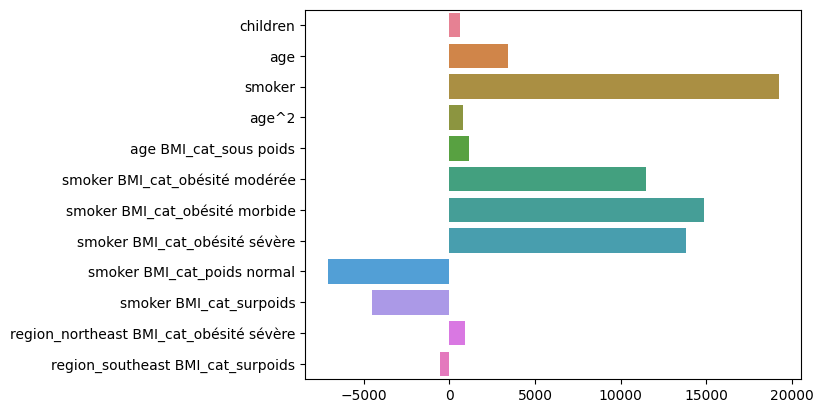

In [709]:
sns.barplot(coef_sorted, orient='h')

ValueError: This Lasso estimator requires y to be passed, but the target y is None.

In [ ]:
#Ridge

ridge_model = make_pipeline(preprocessor, Ridge(random_state=42))

param_grid = {
    'ridge__alpha': np.linspace(1,100,100)
}

grid_search = GridSearchCV(
    ridge_model,
    param_grid,
    cv=5,
    scoring='r2'
)


grid_search.fit(X_train,y_train)
grid_search.best_params_

{'ridge__alpha': np.float64(1.0)}

In [ ]:
ridge_model = make_pipeline(preprocessor, Ridge(43,random_state=42))

ridge_model.fit(X_train, y_train)

print("Train score : ", ridge_model.score(X_test,y_test))

Train score :  0.8777883083441873


In [ ]:
import pickle

with open('best_model.pkl', 'wb') as f:  # open a text file
    pickle.dump(best_lasso_model, f)


with open('best_model.pkl', 'rb') as f:
    pickle_model = pickle.load(f)
    client=[[19,'male',0,'yes','southwest',35]]
    client_array= pd.DataFrame(client, columns=["age","sex","children","smoker","region","bmi"])
    print(client_array)
    print(type(client_array))
    # client_array = np.asarray(client).reshape(1,-1)
    pred= pickle_model.predict(client_array)
    print(pred)

   age   sex  children smoker     region  bmi
0   19  male         0    yes  southwest   35
<class 'pandas.core.frame.DataFrame'>
[36170.70666021]
